In [31]:
from quri_parts.core.operator import Operator, pauli_label
from quri_parts.circuit import QuantumCircuit, H, UnboundParametricQuantumCircuit
from quri_parts.core.state import GeneralCircuitQuantumState
from quri_parts.qulacs.circuit import convert_circuit
from quri_parts.qulacs.estimator import create_qulacs_vector_estimator
from quri_parts.qulacs.sampler import create_qulacs_vector_sampler
from quri_parts.qiskit.circuit import convert_circuit as convert_circuit_qiskit
from quri_parts.algo.ansatz import HardwareEfficient

import qulacs
from qulacsvis import circuit_drawer

import matplotlib.pyplot as plt
import numpy as np
from numpy import linalg as LA
from scipy.optimize import minimize

In [32]:
# define some hyperparameters
n_qubits = 3
n_shots = 10 ** 7
tot_qubits = n_qubits + 1
ancilla_idx = n_qubits

In [33]:
# an example of the operator of Quantum Linear Systems Problem (QLSP)
# this is chosen to be the same one used in the supplemental material of arXiv:1909.05820
coefficients = np.array([1.0, 0.2, 0.2])

Id = np.identity(2)
Z = np.array([[1, 0], [0, -1]])
X = np.array([[0, 1], [1, 0]])

A_0 = np.identity(8)
A_1 = np.kron(np.kron(X, Z), Id)
A_2 = np.kron(np.kron(X, Id), Id)

A_sum = coefficients[0] * A_0 + coefficients[1] * A_1 + coefficients[2] * A_2

print(A_sum)

[[1.  0.  0.  0.  0.4 0.  0.  0. ]
 [0.  1.  0.  0.  0.  0.4 0.  0. ]
 [0.  0.  1.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  1.  0.  0.  0.  0. ]
 [0.4 0.  0.  0.  1.  0.  0.  0. ]
 [0.  0.4 0.  0.  0.  1.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  1.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  1. ]]


In [34]:
# an example of the true state we would like to solve
ket_b = np.ones(8) / np.sqrt(8)
#print(ket_b)

In [35]:
# use Hardware-efficient ansatz
ansatz = HardwareEfficient(qubit_count=n_qubits, reps=1).get_mutable_copy()
parameter_count = ansatz.parameter_count

In [36]:
def local_Hadamard_test(parameters, idx1=None, idx2=None, idx3=None, RorI=None):
    
    circuit = QuantumCircuit(tot_qubits)
    
    # 1st Hadamard gate for the ancillary qubit
    circuit.add_H_gate(ancilla_idx)

    # for getting the imaginary part, we need to add a -i factor to the ancillary qubit
    if RorI == "im":
        circuit.add_Sdag_gate(ancilla_idx)

    circuit += ansatz.bind_parameters(parameters)

    # controlled A_l components
    if idx1 == 0:
        None

    elif idx1 == 1:
        circuit.add_CNOT_gate(ancilla_idx, 0)
        circuit.add_CZ_gate(ancilla_idx, 1)

    elif idx1 == 2:
        circuit.add_CNOT_gate(ancilla_idx, 0)
    
    # Udag for <0|Udag = <b|
    for i in range(n_qubits):
        circuit.add_gate(H(i))
    
    # controlled Z at idx3, if -1 -> identity (do not add any gates), the -1 option is set for later use
    if idx3 != -1:
        circuit.add_CZ_gate(ancilla_idx, idx3)
    
    # U for U|0> = |b>
    for i in range(n_qubits):
        circuit.add_gate(H(i))
    
    # controlled Adag_l components
    if idx2 == 0:
        None
    
    elif idx2 == 1:
        circuit.add_CNOT_gate(ancilla_idx, 0)
        circuit.add_CZ_gate(ancilla_idx, 1)

    elif idx2 == 2:
        circuit.add_CNOT_gate(ancilla_idx, 0)

    # 2nd Hadamard gate for the ancillary qubit
    circuit.add_H_gate(ancilla_idx)
    
    circuit_state = GeneralCircuitQuantumState(tot_qubits, circuit)
    
    op = Operator({
    pauli_label("Z3"): 1.0,
    })
    estimator = create_qulacs_vector_estimator()
    exp_ancillary = estimator(op, circuit_state)
    
    return exp_ancillary.value.real

In [37]:
# define an inner product for later use
def inner_product(parameters, idx1=None, idx2=None, idx3=None):
    real_part = local_Hadamard_test(parameters, idx1=idx1, idx2=idx2, idx3=idx3, RorI="re")
    imaginary_part = local_Hadamard_test(parameters, idx1=idx1, idx2=idx2, idx3=idx3, RorI="im")
    
    return real_part + 1.0j * imaginary_part

In [38]:
# return <\psi|\psi> = <x|AdagA|x>
def xAdagAx(parameters):
    norm = 0.0

    for idx1 in range(len(coefficients)):
        for idx2 in range(len(coefficients)):
            norm += coefficients[idx1] * np.conj(coefficients[idx2]) * inner_product(parameters, idx1, idx2, -1)
    
    return abs(norm)

In [39]:
# return <x|AdagU(controlled operator)UdagA|x>
def cost_function(parameters):
    inner_product_sum = 0

    for idx1 in range(0, len(coefficients)):
        for idx2 in range(0, len(coefficients)):
            for idx3 in range(0, n_qubits):
                inner_product_sum += coefficients[idx1] * np.conj(coefficients[idx2]) * inner_product(parameters, idx1, idx2, idx3)

    inner_product_sum = abs(inner_product_sum)
    
    return 0.5 - 0.5 * inner_product_sum / (n_qubits * xAdagAx(parameters))

In [40]:
# run the cost function
parameter_histroy = []
cost_history = []

init_params = np.array([np.random.random() for i in range(parameter_count)])

parameter_histroy.append(init_params)
cost_history.append(cost_function(init_params))

bfgs_options = {
        "gtol": 1e-9,
        }

result = minimize(cost_function, init_params, method="BFGS", callback=lambda x: (parameter_histroy.append(x), cost_history.append(cost_function(x))))

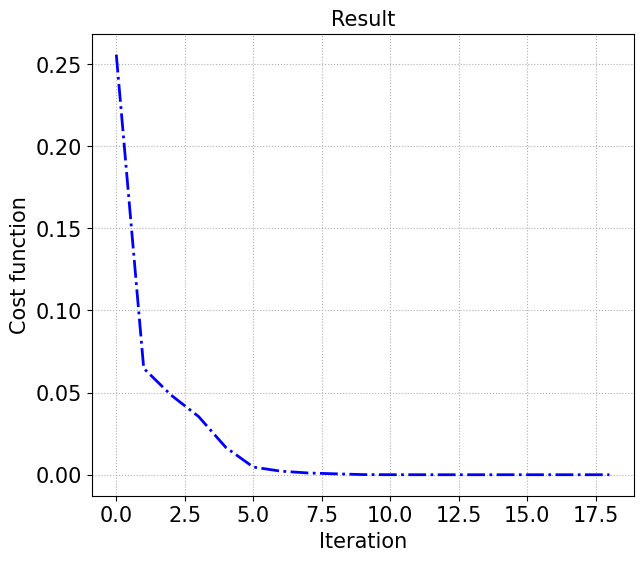

In [41]:
plt.figure(figsize=(7.0, 6.0))
plt.title("Result", fontsize=15)
plt.plot(cost_history, color="blue", linewidth=2.0, linestyle="dashdot")
plt.xlabel("Iteration", fontsize=15)
plt.ylabel("Cost function", fontsize=15)
#plt.yscale("log")
plt.xticks(fontsize=15, rotation=0)
plt.yticks(fontsize=15, rotation=0)
plt.grid(linestyle='dotted')
#plt.legend(loc='upper right', fontsize=15, framealpha=0.5)

plt.show()

In [42]:
# check the probability of each component
qulacs_circuit = convert_circuit(ansatz.bind_parameters(parameter_histroy[-1]))
ket_x = qulacs.QuantumState(n_qubits)
qulacs_circuit.update_quantum_state(ket_x)

ket_x = ket_x.get_vector()

print((ket_x * np.conj(ket_x)).real)

[0.08445989 0.08446049 0.16555226 0.16554579 0.08445661 0.08445437
 0.1655371  0.16553348]


In [43]:
# we can do a sampling simulation
sampler = create_qulacs_vector_sampler()
sampling_result = sampler(ansatz.bind_parameters(parameter_histroy[-1]), shots=n_shots)
print(sampling_result)

{0: 844687, 1: 847353, 2: 1654627, 3: 1654884, 4: 842764, 5: 843255, 6: 1657698, 7: 1654732}


In [44]:
# obtain the sampling result
samples = []
keys = np.array(list(sampling_result.keys()), dtype=object)
values = np.array(list(sampling_result.values()))

for i in range(len(keys)):
    samples.append(values[i]/n_shots) 

print(samples)

[0.0844687, 0.0847353, 0.1654627, 0.1654884, 0.0842764, 0.0843255, 0.1657698, 0.1654732]


In [45]:
# calculate the answer |x> classically by matrix inversion |x> = A^{-1}|b>
A_sum_inv = LA.inv(A_sum)
ket_x = np.dot(A_sum_inv, ket_b)

ket_x_norm = (ket_x / np.linalg.norm(ket_x)) ** 2
print(ket_x_norm)

[0.08445946 0.08445946 0.16554054 0.16554054 0.08445946 0.08445946
 0.16554054 0.16554054]


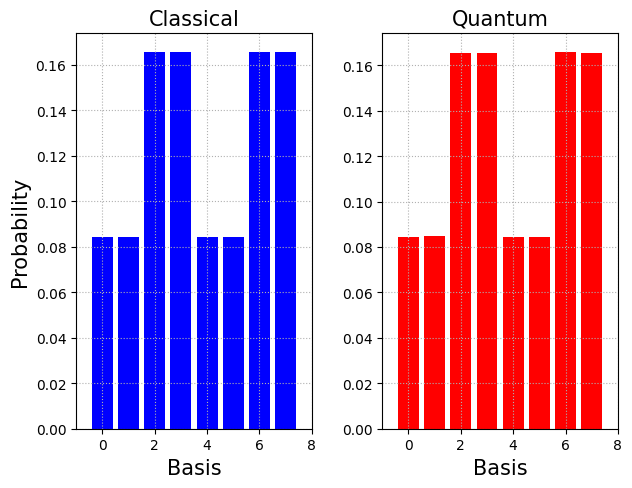

In [46]:
# we see that the result of VQLS is consistent with the classical result
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.tight_layout(pad=2.0)
ax1.set_title("Classical", fontsize=15)
ax1.bar(np.arange(0, 2 ** n_qubits), ket_x_norm, color="blue")
ax1.set_xlim(-1.0, 2 ** n_qubits)
ax1.set_xlabel("Basis", fontsize=15)
ax1.set_ylabel("Probability", fontsize=15)
ax1.grid(linestyle='dotted')

ax2.set_title("Quantum", fontsize=15)
ax2.bar(np.arange(0, 2 ** n_qubits), samples, color="red")
ax2.set_xlim(-1.0, 2 ** n_qubits)
ax2.set_xlabel("Basis", fontsize=15)
ax2.grid(linestyle='dotted')

plt.show()